In [1]:
print("The start of Optimisation HW1!")
print("These are not the droids you're looking for")

The start of Optimisation HW1!
These are not the droids you're looking for


In [2]:
#Import relevant libraries
import sklearn
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
import scipy.linalg
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time

In [3]:
random.seed(69)
np.random.seed(69)

In [4]:
def createDataset():
    #Let's start to generate the points using two functions: sine and cosine
    range = (-5*np.pi, 5*np.pi)
    n = 5000 #number of points
    #perm = np.random.permutation(n//2)
    x_0 = np.random.uniform(*range, n//2)
    f_sin = np.sin(0.6*x_0) #function for class -1
    f_cos = np.cos(0.6*x_0+np.pi/2) #fuction for class 1

    #Visualize the graphs without noise
    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Graphs of sin and cos without noise")
    plt.scatter(x_0, f_sin, alpha=0.6, s=30, color="m")
    plt.scatter(x_0, f_cos, alpha=0.6, s=30, color="c")
    plt.legend(["Class -1 (sin)", "Class 1 (cos)"])
    plt.xlim(-15, 15)
    plt.ylim(-2, 2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    #Let's add some noise 
    noise = np.random.normal(0, 0.1, len(x_0))
    new_fsin = f_sin + noise
    new_fcos = f_cos + noise 

    #Graphs visualization with noise 
    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Graphs of sin and cos with noise")
    plt.scatter(x_0, new_fsin, alpha=0.6, s=30, color="m")
    plt.scatter(x_0, new_fcos, alpha=0.6, s=30, color="c")
    plt.legend(["Class -1 (sin)", "Class 1 (cos)"])
    plt.xlim(-15, 15)
    plt.ylim(-2, 2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    class_0 = np.array(list(zip(x_0, new_fsin)))
    class_1 = np.array(list(zip(x_0, new_fcos)))

    return class_0, class_1

def split_data(class0, class1, labeled_pct, initialize_random=True):
    scaler = StandardScaler().fit(np.concatenate((class0, class1)))
    split_0 = int(len(class0) * labeled_pct) #number of data with labels according to percentage provided for class 0
    split_1 = int(len(class1) * labeled_pct) #same for class 1

    x_bar_0 = scaler.transform(class0[:split_0]) #transforms on the range of the labeled data 
    x_bar_1 = scaler.transform(class1[:split_1])
    x_0 = scaler.transform(class0[split_0:]) #transforms on the range of the unlabeled data 
    x_1 = scaler.transform(class1[split_1:])

    #Creating the labels and variables for label and unlabel data 
    y_bar_0 = np.full(len(x_bar_0), -1) #assigns -1 to a vector of size x_bar_0, creating labeled data for class -1
    y_bar_1 = np.full(len(x_bar_1), 1)  #assigns 1 to a vector of size x_bar_1, creating labeled data for class 1 
    y_0 = np.full(len(x_0), -1) #creating the target vector for class -1
    y_1 = np.full(len(x_1), 1) #creating the target vector for class 1 

    #Concatenates variables of both classes to create label 
    x_labeled = np.concatenate((x_bar_0, x_bar_1)) #list of coordinates (x, y) of labeled data 
    y_labeled = np.concatenate((y_bar_0, y_bar_1)) #list of classes 
    
    """# Shuffle labeled set
    perm_labeled = np.random.permutation(len(x_labeled))
    x_labeled = x_labeled[perm_labeled]
    y_labeled = y_labeled[perm_labeled]
    """
    #Concatenates variables of both classes to create unlabel variables 
    x_unlabeled = np.concatenate((x_0, x_1)) #list of coordiantes (x, y) of unlabeled data
    y_unlabeled_target = np.concatenate((y_0, y_1)) #list of target classes

    """
    # Shuffle unlabeled set
    perm_unlabeled = np.random.permutation(len(x_unlabeled))
    x_unlabeled = x_unlabeled[perm_unlabeled]
    y_unlabeled_target = y_unlabeled_target[perm_unlabeled]
    """

    #2 ways to initialize the labels to predict 
    if initialize_random:
        y_unlabeled_initial = np.random.choice([-1, 1], len(x_unlabeled))
    else:
        y_unlabeled_initial = np.zeros(len(x_unlabeled))

    return x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial

def plottingData(x_labeled, y_labeled, x_unlabeled, y_unlabeled_target):
    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Unlabeled points true value")
    plt.scatter([p[0] for p in x_unlabeled[y_unlabeled_target == -1]], [p[1] for p in x_unlabeled[y_unlabeled_target == -1]], alpha=0.6, s=30, color="m")
    plt.scatter([p[0] for p in x_unlabeled[y_unlabeled_target == 1]], [p[1] for p in x_unlabeled[y_unlabeled_target == 1]], alpha=0.6, s=30, color="c")
    plt.legend(["Class -1", "Class 1"])
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Labeled points true value")
    plt.scatter([p[0] for p in x_labeled[y_labeled == -1]], [p[1] for p in x_labeled[y_labeled == -1]], alpha=0.6, s=30, color="m")
    plt.scatter([p[0] for p in x_labeled[y_labeled == 1]], [p[1] for p in x_labeled[y_labeled == 1]], alpha=0.6, s=30, color="c")
    plt.legend(["Class -1", "Class 1"])
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Labeled and unlabeled points")
    plt.scatter([p[0] for p in x_unlabeled], [p[1] for p in x_unlabeled], c="grey")
    plt.scatter([p[0] for p in x_labeled[y_labeled == -1]], [p[1] for p in x_labeled[y_labeled == -1]], alpha=0.6, s=30, color="m")
    plt.scatter([p[0] for p in x_labeled[y_labeled == 1]], [p[1] for p in x_labeled[y_labeled == 1]], alpha=0.6, s=30, color="c")
    plt.legend(["Unlabeled", "Labeled -1", "Labeled 1"])
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    return 

def prepareArtifitialData():
    class0, class1 = createDataset()
    x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial = split_data(class0, class1, 0.1)
    plottingData(x_labeled, y_labeled, x_unlabeled, y_unlabeled_target)
    return x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial

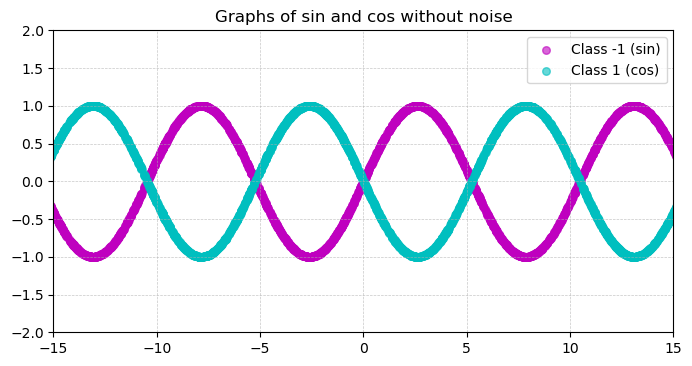

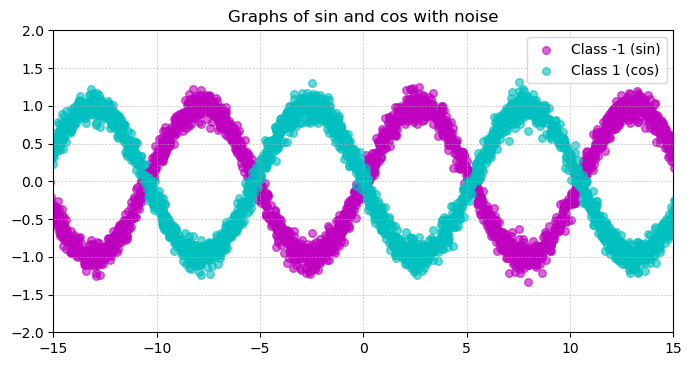

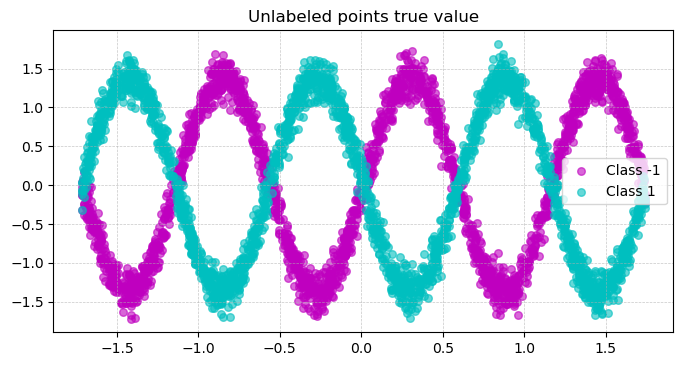

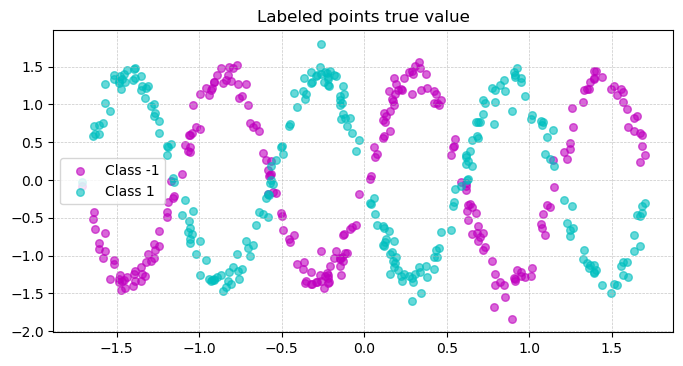

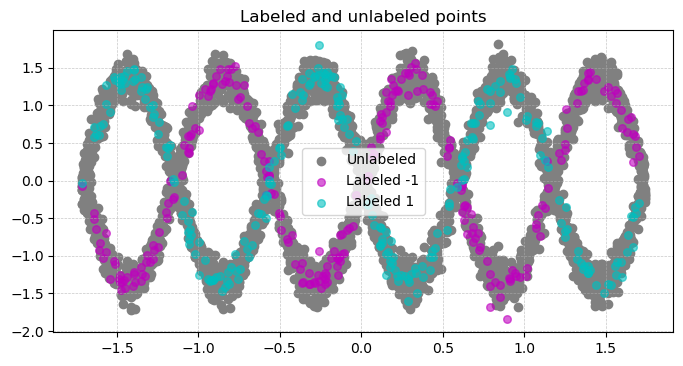

In [5]:
x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial = prepareArtifitialData()

In [6]:
# Define weight arrays using Gaussian (RBF) Kernel as similarity measure 

def computeWeights(x_labeled, x_unlabeled):
    #Array w_ij is the weights array between labeled examples and unlabeled examples
    dist_labeled_unlabeled = cdist(x_labeled, x_unlabeled, metric='euclidean')
    w_ij = np.exp(-0.5 * dist_labeled_unlabeled ** 2)

    #Array w_ij_bar is the weights array between unlabeled examples and unlabeled examples
    dist_unlabeled_unlabeled = cdist(x_unlabeled, x_unlabeled, metric='euclidean')
    w_ij_bar = np.exp(-0.5 * dist_unlabeled_unlabeled ** 2)

    print(w_ij.shape, w_ij_bar.shape)
    return w_ij, w_ij_bar

#Define the loss function

def loss(w_ij, w_ij_bar, given_labels, predicted_labels):
    
   #Representing points as vectors for ease of calculations
    y = np.copy(predicted_labels).astype("float64").reshape((-1,1))
    y_bar = np.copy(given_labels).astype("float64").reshape((-1,1))

    diff_t1 = y-y_bar.T
    diff_t1_sq = np.power(diff_t1,2)
    loss_matrix_t1 = diff_t1_sq*w_ij.T
    total_loss_t1 = np.sum(loss_matrix_t1)

    diff_t2 = y-y.T
    diff_t2_sq = np.power(diff_t2,2)
    loss_matrix_t2 = diff_t2_sq*w_ij_bar.T
    total_loss_t2 = np.sum(loss_matrix_t2)

    return total_loss_t1 + total_loss_t2

In [7]:
#Define accuracy measures
# accuracy score, rounding current to {-1,1} and comparing with target

def accuracy2(current_prediction):
    return accuracy_score(y_unlabeled_target, current_prediction)


In [8]:
#Define Hessian Matrix to estimate Lipschitz constant

USE_LIPSCHITZ_CONSTANT = True
OUTPUT_STEP = 0.1
OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM = False
STEP_SIZE = 1e-2

def hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled, target, OUTPUT_STEP = 0.1):
    mat = np.copy(-w_unlabeled_unlabeled)
    for i in range(len(target)):
        if i % (len(target) * OUTPUT_STEP) == 0 :
            print(f"{int(i/len(target)*100):02}% ... ", end="")
        mat[i][i] = np.sum(w_labeled_unlabeled[:,i]) + np.sum(w_unlabeled_unlabeled[:,i]) - w_unlabeled_unlabeled[i][i]
    print()
    return mat * 2

def estimate_lipschitz_constant(hessian):
    # max eigvalue
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]

def estimate_degree_strongly_convex(hessian):
    # min eigvalue
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

def computeLCons(w_ij, w_ij_bar, target, USE_LIPSCHITZ_CONSTANT = True, OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM = False, STEP_SIZE = 1e-2):
    if USE_LIPSCHITZ_CONSTANT:
        print("Calculating the Hessian matrix")
        hessian = hessian_matrix(w_ij_bar, w_ij, target)
        print("Calculating sigma (strongly convex)")
        sigma = estimate_degree_strongly_convex(hessian)
        strongly_convex = sigma > 0
        print(f"Sigma: {sigma}, {'' if strongly_convex else 'not'} strongly convex")
        print("Estimating Lipschitz constant for the whole function")
        L = estimate_lipschitz_constant(hessian)
        print(f"Lipschitz constant: {L}")
        print("Estimating Lipschitz constant for each single variable")
        Li = np.array([hessian[i][i] for i in range(len(hessian))], dtype='float64') \
            if OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM \
            else np.repeat(L, len(hessian))
    else:
        print("Using fixed step size")
        sigma = 0
        strongly_convex = False
        L = 1/STEP_SIZE
        Li = np.repeat(L, len(y_unlabeled_target))
    print("Done")
    return L, Li

In [9]:
#Calculating constants that will be used in the Gradient Descent Method
def computeConstants(w_ij, w_ij_bar, labels):
    print("Calculating coefficients of the gradient")
    row_sum_w = np.sum(w_ij, axis=0).reshape((-1,1))
    row_sum_w_ = np.sum(w_ij_bar, axis=0).reshape((-1,1))
    Cij = (row_sum_w + row_sum_w_)
    b = np.multiply(
        labels.reshape((-1,1)),
        w_ij
    ).sum(0).reshape((-1,1))
    print("Done")
    return Cij, b

In [10]:
w_ij, w_ij_bar = computeWeights(x_labeled, x_unlabeled)
L, Li = computeLCons(w_ij, w_ij_bar, y_unlabeled_target)
Cij, b = computeConstants(w_ij, w_ij_bar, y_labeled)

(500, 4500) (4500, 4500)
Calculating the Hessian matrix
00% ... 10% ... 20% ... 30% ... 40% ... 50% ... 60% ... 70% ... 80% ... 90% ... 
Calculating sigma (strongly convex)
Sigma: 311.6870230347745,  strongly convex
Estimating Lipschitz constant for the whole function
Lipschitz constant: 4276.360832288768
Estimating Lipschitz constant for each single variable
Done
Calculating coefficients of the gradient
Done


In [11]:
#Defining the gradient function

def gradient(w_ij, w_ij_bar, y):
    unlabeled = y.reshape((-1,1))
    third_coeff = np.dot(w_ij_bar.T, unlabeled)
    return 2 * (Cij * unlabeled - b - third_coeff).reshape((-1,))

#Defining functions for the gradient calculation for block selection

def derivative(y, j):
    return 2 * (Cij[j] * y[j] -
           b[j] -
           np.matmul(w_ij_bar[:,j], y.T))

def update_gradient(w_ij, w_ij_bar, previous_grad, Li, index):
    #global w_ij_bar, Cij
    step = 1/Li * previous_grad[index]
    new_grad = np.copy(previous_grad)
    new_grad += 2* w_ij_bar[index] * step
    new_grad[index] -= 2 * Cij[index] * step
    return step, new_grad

In [12]:
y_unlabeled_gd = np.copy(y_unlabeled_initial)

In [13]:
print(y_unlabeled_gd[0:10])

[ 1 -1 -1 -1  1  1 -1  1 -1 -1]


In [14]:
#Implementation of GD
def GD(NUM_ITERS, y_unlabeled, EPSILON = 1e-11):

    ticks_gd = [0]
    accuracies_gd = [accuracy2(y_unlabeled)]
    losses_gd = [loss(w_ij, w_ij_bar, y_labeled, y_unlabeled)]
    init_time = time.time() * 1000
    for i in range(NUM_ITERS):
        if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
            print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")

        start = time.process_time()
        grad = gradient(w_ij, w_ij_bar, y_unlabeled)

        if EPSILON >= np.linalg.norm(grad):
            break

        y_unlabeled = y_unlabeled - 1/L * grad
        y_unlabeled_gd_hard= np.where(y_unlabeled > 0, 1, -1)  # Converts to 1 or -1, from soft to hard predictions
        accuracies_gd.append(accuracy2(y_unlabeled_gd_hard))
        losses_gd.append(loss(w_ij, w_ij_bar, y_labeled, y_unlabeled))
        ticks_gd.append(time.time() * 1000 - init_time)

        if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
            print(f" - final accuracy {(accuracies_gd[-1])*100:05.2f}% - loss {losses_gd[-1]:05.2f}")

    print(f"""
    Final accuracy: {round(accuracies_gd[-1]* 100, 2)}%
    Norm gradient: {np.linalg.norm(gradient(w_ij, w_ij_bar, y_unlabeled))}
    Loss: {loss(w_ij, w_ij_bar, y_labeled, y_unlabeled)}
    """)
    return y_unlabeled, ticks_gd, accuracies_gd, losses_gd

In [15]:
y_unlabeled_gd, ticks_gd, accuracies_gd, losses_gd = GD(50, y_unlabeled_gd) #review 

00% - iter 0 / 50 - final accuracy 49.47% - loss 1794641.62
10% - iter 5 / 50 - final accuracy 56.29% - loss 707328.66
20% - iter 10 / 50 - final accuracy 56.76% - loss 706924.79
30% - iter 15 / 50 - final accuracy 55.98% - loss 706934.61
40% - iter 20 / 50 - final accuracy 55.58% - loss 706935.70
50% - iter 25 / 50 - final accuracy 55.33% - loss 706935.73
60% - iter 30 / 50 - final accuracy 55.18% - loss 706935.67
70% - iter 35 / 50 - final accuracy 55.09% - loss 706935.63
80% - iter 40 / 50 - final accuracy 55.07% - loss 706935.61
90% - iter 45 / 50 - final accuracy 55.02% - loss 706935.60

    Final accuracy: 54.96%
    Norm gradient: 1.5088865261492057
    Loss: 706935.593570906
    


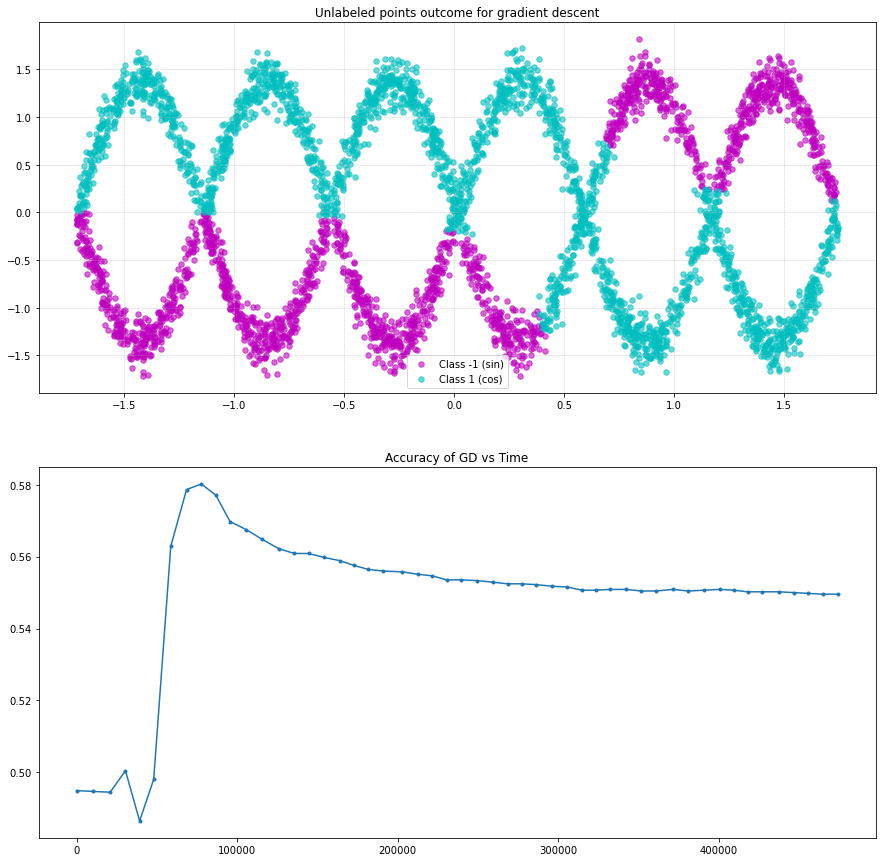

In [16]:
figure, axis = plt.subplots(2,1)

final_y_unlabeled = (y_unlabeled_gd/2 + .5).round() * 2 - 1
axis[0].scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]], alpha=0.6, s=30, color="m")     
axis[0].scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]], alpha=0.6, s=30, color="c")
axis[0].set_title("Unlabeled points outcome for gradient descent")
axis[0].legend(["Class -1 (sin)", "Class 1 (cos)"])
axis[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

axis[1].set_title("Accuracy of GD vs Time")
axis[1].plot(ticks_gd, accuracies_gd, marker='.')

figure.set_figheight(15)
figure.set_figwidth(15)

plt.show()


In [17]:
y_unlabeled_bcgd_gs = np.copy(y_unlabeled_initial).astype("float64")
y_unlabeled_bcgd_random = np.copy(y_unlabeled_initial).astype("float64")

In [18]:
#Implement the BCGD with GS
def BCGD(NUM_ITERS, y_unlabeled_bcgd, EPSILON = 1e-11):

    ticks_bcgd_gs = [0]
    accuracies_bcgd_gs = [accuracy2(y_unlabeled_bcgd)]
    losses_bcgm_gs = [loss(w_ij, w_ij_bar, y_labeled, y_unlabeled_bcgd)]

    max_iterations = NUM_ITERS*len(y_unlabeled_bcgd)
    previous_grad_gs = gradient(w_ij, w_ij_bar, y_unlabeled_bcgd)

    init_time = time.time() * 1000

    for i in range(max_iterations):
        if i % (max_iterations * OUTPUT_STEP) == 0 :
            print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

        index = np.argmax(np.abs(previous_grad_gs))

        step, new_grad = update_gradient(w_ij, w_ij_bar, previous_grad_gs, Li[index], index)
        y_unlabeled_bcgd[index] = y_unlabeled_bcgd[index] - step
        previous_grad_gs = new_grad

        if EPSILON >= np.linalg.norm(previous_grad_gs):
            break

        if (i+1) % len(y_unlabeled_target) == 0:
            y_unlabeled_bcgd_hard= np.where(y_unlabeled_bcgd > 0, 1, -1)
            accuracies_bcgd_gs.append(accuracy2(y_unlabeled_bcgd_hard))
            losses_bcgm_gs.append(loss(w_ij, w_ij_bar, y_labeled, y_unlabeled_bcgd))
            ticks_bcgd_gs.append(time.time() * 1000 - init_time)

        if i % (max_iterations * OUTPUT_STEP) == 0 :
            print(f" - final accuracy {(accuracies_bcgd_gs[-1])*100:05.2f}% - loss {loss(w_ij, w_ij_bar, y_labeled, y_unlabeled_bcgd):05.2f}")


    print(f"""
    Final accuracy: {round(accuracies_bcgd_gs[-1]* 100, 2)}%
    Norm gradient: {np.linalg.norm(gradient(w_ij, w_ij_bar, y_unlabeled_bcgd))}
    Loss: {loss(w_ij, w_ij_bar, y_labeled, y_unlabeled_bcgd)}
    """)
    return y_unlabeled_bcgd, ticks_bcgd_gs, accuracies_bcgd_gs, losses_bcgm_gs

In [19]:
y_unlabeled_bcgd_gs, ticks_bcgd_gs, accuracies_bcgd_gs, losses_bcgm_gs = BCGD(50, y_unlabeled_bcgd_gs)

00% - iter 0 / 225000 - final accuracy 49.49% - loss 13884600.62
10% - iter 22500 / 225000 - final accuracy 50.00% - loss 709452.74
20% - iter 45000 / 225000 - final accuracy 50.07% - loss 707494.99
30% - iter 67500 / 225000 - final accuracy 52.51% - loss 707114.14
40% - iter 90000 / 225000 - final accuracy 58.07% - loss 706990.62
50% - iter 112500 / 225000 - final accuracy 62.18% - loss 706953.01
60% - iter 135000 / 225000 - final accuracy 60.22% - loss 706941.19
70% - iter 157500 / 225000 - final accuracy 56.84% - loss 706937.50
80% - iter 180000 / 225000 - final accuracy 55.84% - loss 706936.14
90% - iter 202500 / 225000 - final accuracy 55.33% - loss 706935.83

    Final accuracy: 55.13%
    Norm gradient: 6.136018504471162
    Loss: 706935.6879954443
    


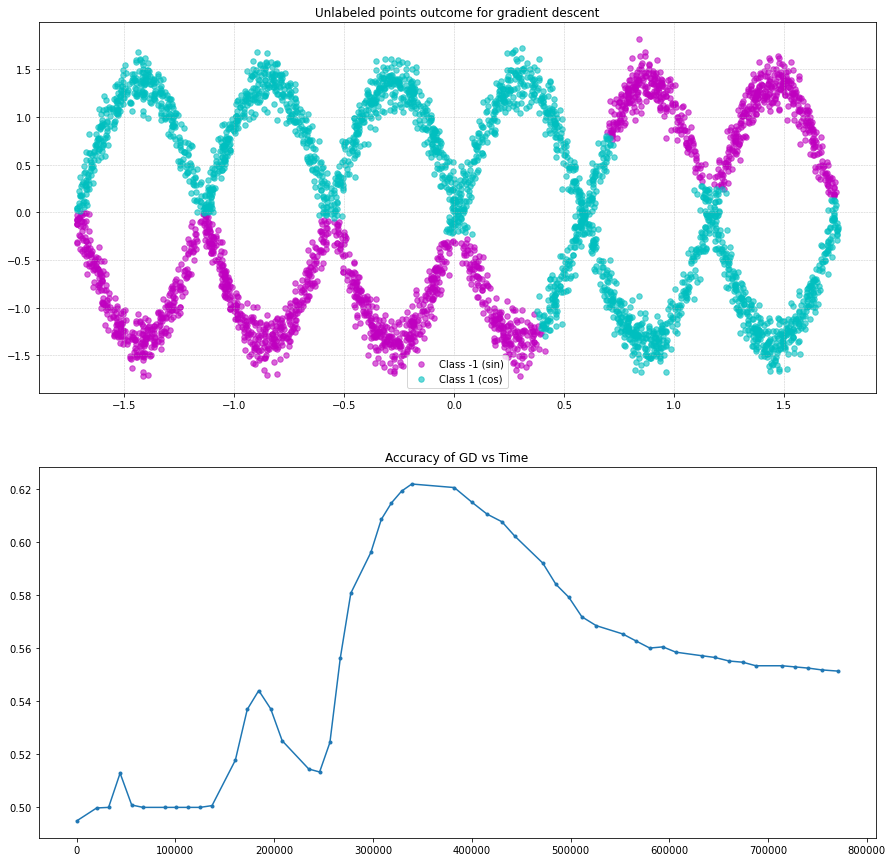

In [20]:
figure, axis = plt.subplots(2,1)

final_y_unlabeled = (y_unlabeled_bcgd_gs/2 + .5).round() * 2 - 1
axis[0].scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]], alpha=0.6, s=30, color="m")     
axis[0].scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]], alpha=0.6, s=30, color="c")
axis[0].set_title("Unlabeled points outcome for gradient descent")
axis[0].legend(["Class -1 (sin)", "Class 1 (cos)"])
axis[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

axis[1].set_title("Accuracy of GD vs Time")
axis[1].plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')

figure.set_figheight(15)
figure.set_figwidth(15)

plt.show()


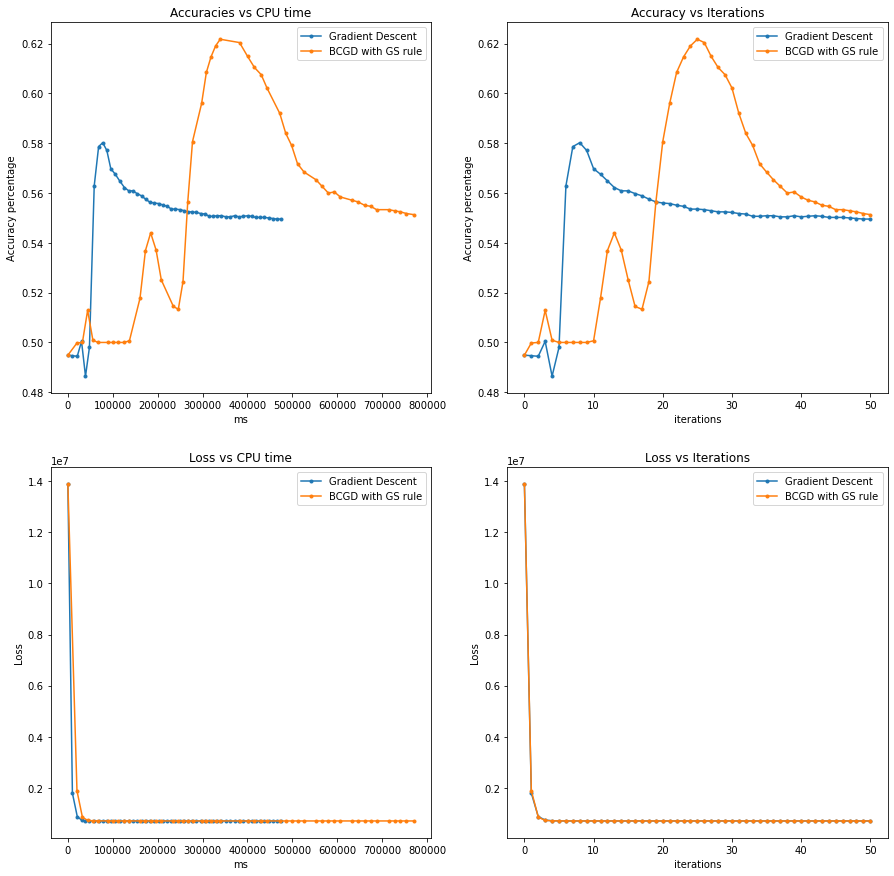

In [21]:
figure, axis = plt.subplots(2,2)

axis[0,0].set_title("Accuracies vs CPU time")
axis[0,0].plot(ticks_gd, accuracies_gd, marker='.')
axis[0,0].plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')
axis[0,0].set_xlabel("ms")  
axis[0,0].set_ylabel("Accuracy percentage")  
axis[0,0].legend(["Gradient Descent", "BCGD with GS rule"])

axis[0,1].set_title("Accuracy vs Iterations")
axis[0,1].plot(accuracies_gd, marker = '.')
axis[0,1].plot(accuracies_bcgd_gs, marker = '.')
axis[0,1].set_xlabel("iterations")  
axis[0,1].set_ylabel("Accuracy percentage")
axis[0,1].legend(["Gradient Descent", "BCGD with GS rule"])

axis[1,0].set_title("Loss vs CPU time")
axis[1,0].plot(ticks_gd, losses_gd, marker='.')
axis[1,0].plot(ticks_bcgd_gs, losses_bcgm_gs, marker='.')
axis[1,0].set_xlabel("ms")  
axis[1,0].set_ylabel("Loss") 
axis[1,0].legend(["Gradient Descent", "BCGD with GS rule"])

axis[1,1].set_title("Loss vs Iterations")
axis[1,1].plot(losses_gd, marker = '.')
axis[1,1].plot(losses_bcgm_gs, marker = '.')
axis[1,1].set_xlabel("iterations")  
axis[1,1].set_ylabel("Loss") 
axis[1,1].legend(["Gradient Descent", "BCGD with GS rule"])

figure.set_figheight(15)
figure.set_figwidth(15)

plt.show()

In [24]:
def getpublicData():
    #Necessary to use the public dataset
    !pip3 install -U ucimlrepo

    from ucimlrepo import fetch_ucirepo

    # fetch dataset
    breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

    # data (as pandas dataframes)
    X = breast_cancer_wisconsin_diagnostic.data.features #we save the features of our data 
    y = breast_cancer_wisconsin_diagnostic.data.targets #and the labels 

    # metadata
    print(breast_cancer_wisconsin_diagnostic.metadata)

    # variable information
    print(breast_cancer_wisconsin_diagnostic.variables)
    return X, y

def preparePublicData(X, y_labels):
    x_pb = X[:]["radius1"] #radius1 will be coordinate x
    y_pb = X[:]["texture1"] #texture1 will be coordinate y 

    mask_B = y_labels["Diagnosis"]=="B" #filters the data labeled with B
    indices_B = list(y_labels[mask_B].index) #obtains the indices for B
    indices_M = list(y_labels[-mask_B].index) #obtains the indices for M 

    x_B = x_pb[indices_B] #coordinates x of benign 
    x_M = x_pb[indices_M] #coordinates x of malignant

    y_B = y_pb[indices_B] #coordinates y of benign
    y_M = y_pb[indices_M] #coordinates y of malignant

    points_B = np.array(list(zip(x_B, y_B))) #gets points labeled with B
    points_M = np.array(list(zip(x_M, y_M))) #gets points labeled with M

    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Breast Cancer Dataset")
    plt.scatter(x_B, y_B, alpha=0.6, s=30, color="m")
    plt.scatter(x_M, y_M, alpha=0.6, s=30, color="c")
    plt.legend(["Benign", "Malignant"])
    plt.xlabel("Radius")
    plt.ylabel("Texture")
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    return points_B, points_M

In [25]:
X, y_labels = getpublicData()

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

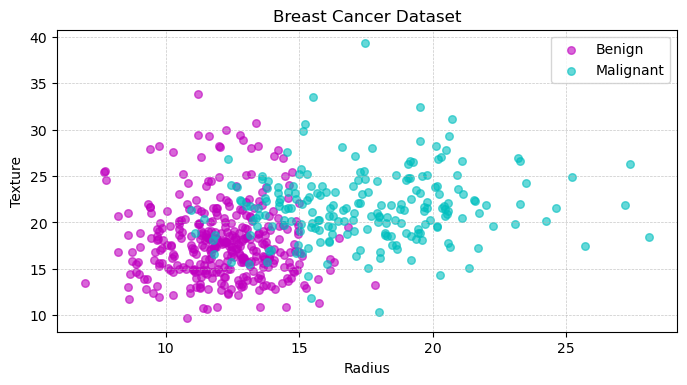

In [26]:
points_B, points_M = preparePublicData(X, y_labels)
x_labeled_pd, y_labeled_pd, x_unlabeled_pd, y_unlabeled_target_pd, y_unlabeled_initial_pd = split_data(points_B, points_M, 0.1)
#-1 would go for B and 1 for M

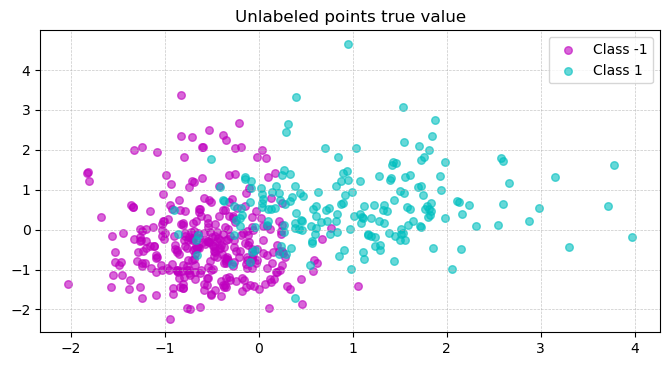

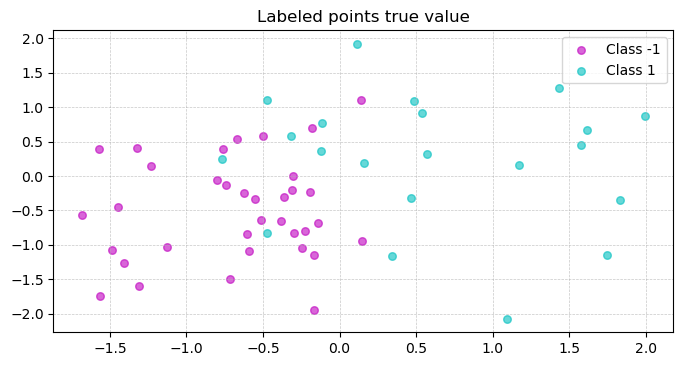

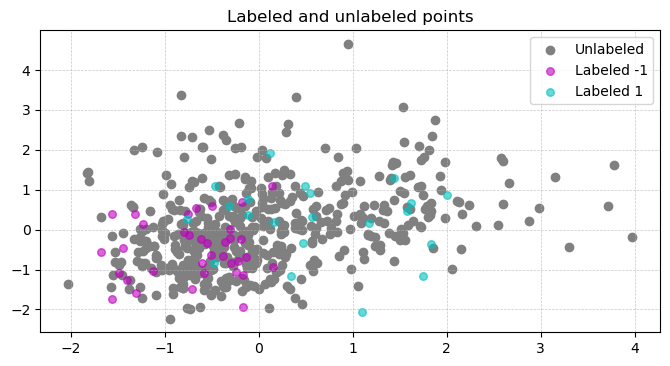

In [27]:
plottingData(x_labeled_pd, y_labeled_pd, x_unlabeled_pd, y_unlabeled_target_pd)

In [28]:
def accuracy3(current_prediction):
    return accuracy_score(y_unlabeled_target_pd, current_prediction)

In [29]:
w_ij_pd, w_ij_bar_pd = computeWeights(x_labeled_pd, x_unlabeled_pd)
L, Li = computeLCons(w_ij_pd, w_ij_bar_pd, y_unlabeled_target_pd)
Cij, b = computeConstants(w_ij_pd, w_ij_bar_pd, y_labeled_pd)

(56, 513) (513, 513)
Calculating the Hessian matrix
00% ... 
Calculating sigma (strongly convex)
Sigma: 3.370648344273935,  strongly convex
Estimating Lipschitz constant for the whole function
Lipschitz constant: 612.8274746775253
Estimating Lipschitz constant for each single variable
Done
Calculating coefficients of the gradient
Done


In [30]:
#Implementation of GD
def GD2(NUM_ITERS, y_unlabeled, EPSILON = 1e-11):

    ticks_gd = [0]
    accuracies_gd = [accuracy3(y_unlabeled)]
    losses_gd = [loss(w_ij_pd, w_ij_bar_pd, y_labeled_pd, y_unlabeled)]
    init_time = time.time() * 1000
    for i in range(NUM_ITERS):
        if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
            print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")

        start = time.process_time()
        grad = gradient(w_ij_pd, w_ij_bar_pd, y_unlabeled)

        if EPSILON >= np.linalg.norm(grad):
            break

        y_unlabeled = y_unlabeled - 1/L * grad
        y_unlabeled_gd_hard= np.where(y_unlabeled > 0, 1, -1)  # Converts to 1 or -1, from soft to hard predictions
        accuracies_gd.append(accuracy3(y_unlabeled_gd_hard))
        losses_gd.append(loss(w_ij_pd, w_ij_bar_pd, y_labeled_pd, y_unlabeled))
        ticks_gd.append(time.time() * 1000 - init_time)

        if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
            print(f" - final accuracy {(accuracies_gd[-1])*100:05.2f}% - loss {losses_gd[-1]:05.2f}")

    print(f"""
    Final accuracy: {round(accuracies_gd[-1]* 100, 2)}%
    Norm gradient: {np.linalg.norm(gradient(w_ij_pd, w_ij_bar_pd, y_unlabeled))}
    Loss: {loss(w_ij_pd, w_ij_bar_pd, y_labeled_pd, y_unlabeled)}
    """)
    return y_unlabeled, ticks_gd, accuracies_gd, losses_gd

In [31]:
y_unlabeled_gd_pd = np.copy(y_unlabeled_initial_pd)
y_unlabeled_gd_pd, ticks_gd_pd, accuracies_gd_pd, losses_gd_pd = GD2(50, y_unlabeled_gd_pd)

00% - iter 0 / 50 - final accuracy 50.68% - loss 29074.09
10% - iter 5 / 50 - final accuracy 67.84% - loss 10301.77
20% - iter 10 / 50 - final accuracy 66.67% - loss 9684.77
30% - iter 15 / 50 - final accuracy 65.11% - loss 9501.12
40% - iter 20 / 50 - final accuracy 63.55% - loss 9414.89
50% - iter 25 / 50 - final accuracy 63.16% - loss 9368.73
60% - iter 30 / 50 - final accuracy 62.77% - loss 9342.41
70% - iter 35 / 50 - final accuracy 62.77% - loss 9326.68
80% - iter 40 / 50 - final accuracy 62.77% - loss 9316.89
90% - iter 45 / 50 - final accuracy 62.96% - loss 9310.58

    Final accuracy: 62.96%
    Norm gradient: 11.8300959722497
    Loss: 9307.094822726343
    


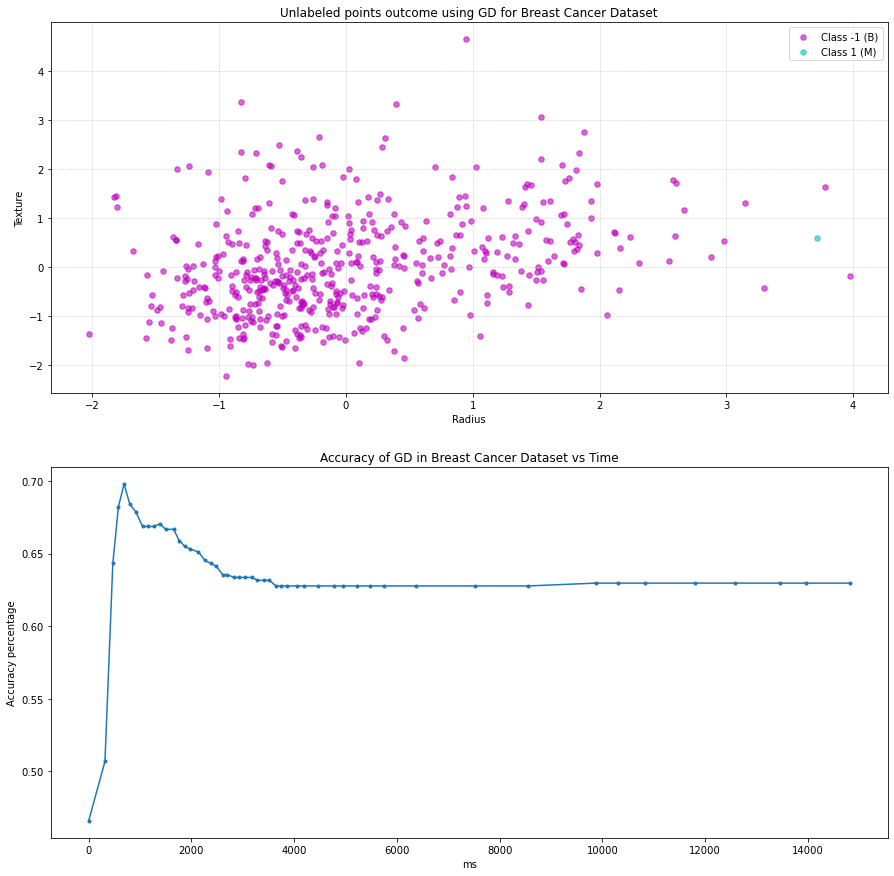

In [32]:
figure, axis = plt.subplots(2,1)

final_y_unlabeled = (y_unlabeled_gd_pd/2 + .5).round() * 2 - 1
axis[0].scatter([p[0] for p in x_unlabeled_pd[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled_pd[final_y_unlabeled == -1]], alpha=0.6, s=30, color="m")     
axis[0].scatter([p[0] for p in x_unlabeled_pd[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled_pd[final_y_unlabeled == 1]], alpha=0.6, s=30, color="c")
axis[0].set_title("Unlabeled points outcome using GD for Breast Cancer Dataset")
axis[0].set_xlabel("Radius")  
axis[0].set_ylabel("Texture")  
axis[0].legend(["Class -1 (B)", "Class 1 (M)"])
axis[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

axis[1].set_title("Accuracy of GD in Breast Cancer Dataset vs Time")
axis[1].plot(ticks_gd_pd, accuracies_gd_pd, marker='.')
axis[1].set_xlabel("ms")  
axis[1].set_ylabel("Accuracy percentage")  

figure.set_figheight(15)
figure.set_figwidth(15)

plt.show()

In [33]:
#Implement the BCGD with GS
def BCGD2(NUM_ITERS, y_unlabeled_bcgd, EPSILON = 1e-11):

    ticks_bcgd_gs = [0]
    accuracies_bcgd_gs = [accuracy3(y_unlabeled_bcgd)]
    losses_bcgm_gs = [loss(w_ij_pd, w_ij_bar_pd, y_labeled_pd, y_unlabeled_bcgd)]

    max_iterations = NUM_ITERS*len(y_unlabeled_bcgd)
    previous_grad_gs = gradient(w_ij_pd, w_ij_bar_pd, y_unlabeled_bcgd)
    init_time = time.time() * 1000

    for i in range(max_iterations):
        if i % (max_iterations * OUTPUT_STEP) == 0 :
            print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

        index = np.argmax(np.abs(previous_grad_gs))

        step, new_grad = update_gradient(w_ij_pd, w_ij_bar_pd, previous_grad_gs, Li[index], index)
        y_unlabeled_bcgd[index] = y_unlabeled_bcgd[index] - step
        previous_grad_gs = new_grad

        if EPSILON >= np.linalg.norm(previous_grad_gs):
            break

        if (i+1) % len(y_unlabeled_target) == 0:
            y_unlabeled_bcgd_hard= np.where(y_unlabeled_bcgd > 0, 1, -1)
            accuracies_bcgd_gs.append(accuracy3(y_unlabeled_bcgd_hard))
            losses_bcgm_gs.append(loss(w_ij_pd, w_ij_bar_pd, y_labeled_pd, y_unlabeled_bcgd))
            ticks_bcgd_gs.append(time.time() * 1000 - init_time)

        if i % (max_iterations * OUTPUT_STEP) == 0 :
            print(f" - final accuracy {(accuracies_bcgd_gs[-1])*100:05.2f}% - loss {loss(w_ij_pd, w_ij_bar_pd, y_labeled_pd, y_unlabeled_bcgd):05.2f}")


    print(f"""
    Final accuracy: {round(accuracies_bcgd_gs[-1]* 100, 2)}%
    Norm gradient: {np.linalg.norm(gradient(w_ij_pd, w_ij_bar_pd, y_unlabeled_bcgd))}
    Loss: {loss(w_ij_pd, w_ij_bar_pd, y_labeled_pd, y_unlabeled_bcgd)}
    """)
    return y_unlabeled_bcgd, ticks_bcgd_gs, accuracies_bcgd_gs, losses_bcgm_gs

In [34]:
y_unlabeled_bcgd_gs_pd = np.copy(y_unlabeled_initial_pd).astype("float64")
y_unlabeled_bcgd_gs_pd, ticks_bcgd_gs_pd, accuracies_bcgd_gs_pd, losses_bcgd_gs_pd = BCGD2(50, y_unlabeled_bcgd_gs_pd)

00% - iter 0 / 25650 - final accuracy 46.59% - loss 211530.16
10% - iter 2565 / 25650 - final accuracy 46.59% - loss 9352.26
20% - iter 5130 / 25650 - final accuracy 62.77% - loss 9295.95
30% - iter 7695 / 25650 - final accuracy 62.77% - loss 9296.02
40% - iter 10260 / 25650 - final accuracy 62.77% - loss 9295.95
50% - iter 12825 / 25650 - final accuracy 62.77% - loss 9296.00
60% - iter 15390 / 25650 - final accuracy 62.77% - loss 9296.05
70% - iter 17955 / 25650 - final accuracy 62.77% - loss 9296.10
80% - iter 20520 / 25650 - final accuracy 62.77% - loss 9296.13
90% - iter 23085 / 25650 - final accuracy 62.77% - loss 9296.16

    Final accuracy: 62.77%
    Norm gradient: 0.037193193581600434
    Loss: 9296.171844619816
    


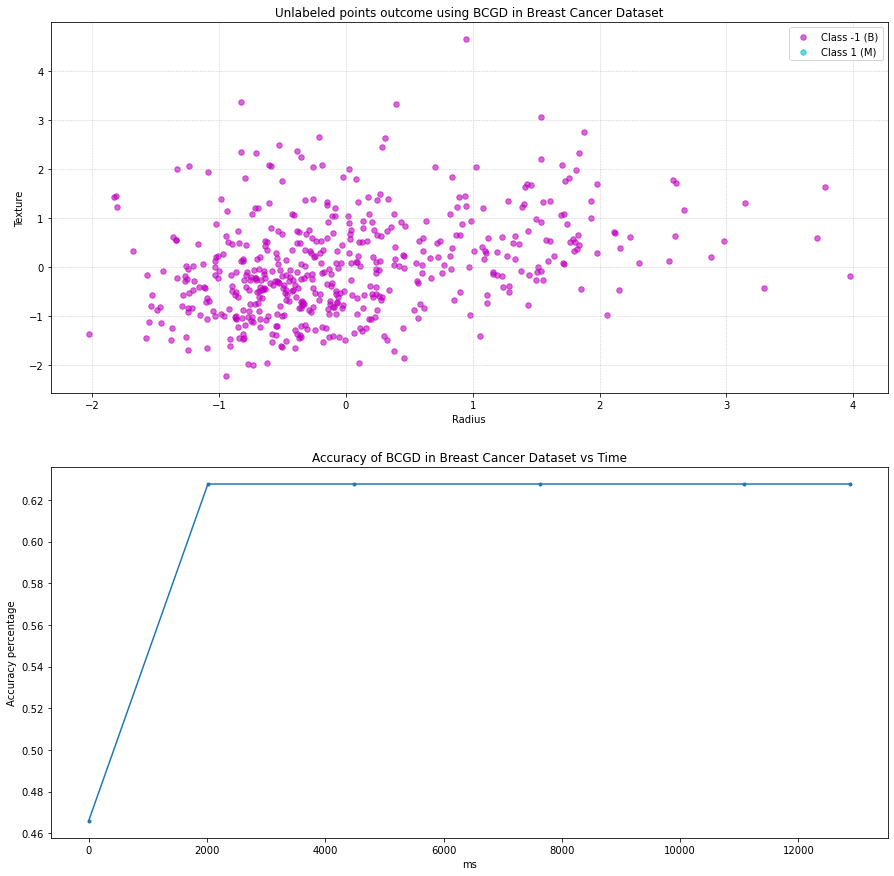

In [35]:
figure, axis = plt.subplots(2,1)

final_y_unlabeled = (y_unlabeled_bcgd_gs_pd/2 + .5).round() * 2 - 1
axis[0].scatter([p[0] for p in x_unlabeled_pd[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled_pd[final_y_unlabeled == -1]], alpha=0.6, s=30, color="m")     
axis[0].scatter([p[0] for p in x_unlabeled_pd[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled_pd[final_y_unlabeled == 1]], alpha=0.6, s=30, color="c")
axis[0].set_title("Unlabeled points outcome using BCGD in Breast Cancer Dataset")
axis[0].set_xlabel("Radius")  
axis[0].set_ylabel("Texture")  
axis[0].legend(["Class -1 (B)", "Class 1 (M)"])
axis[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

axis[1].set_title("Accuracy of BCGD in Breast Cancer Dataset vs Time")
axis[1].plot(ticks_bcgd_gs_pd, accuracies_bcgd_gs_pd, marker='.')
axis[1].set_xlabel("ms")  
axis[1].set_ylabel("Accuracy percentage")  

figure.set_figheight(15)
figure.set_figwidth(15)

plt.show()

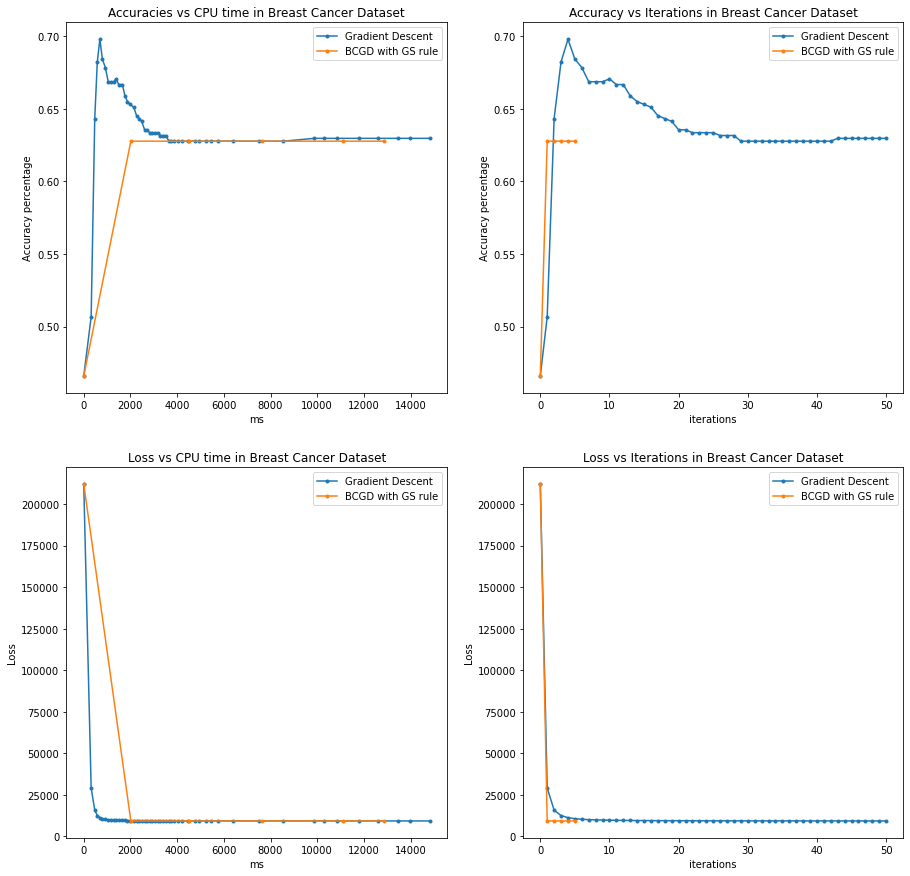

In [36]:
#Comparing boths algorithms in public data 

figure, axis = plt.subplots(2,2)

axis[0,0].set_title("Accuracies vs CPU time in Breast Cancer Dataset")
axis[0,0].plot(ticks_gd_pd, accuracies_gd_pd, marker='.')
axis[0,0].plot(ticks_bcgd_gs_pd, accuracies_bcgd_gs_pd, marker='.')
axis[0,0].set_xlabel("ms")  
axis[0,0].set_ylabel("Accuracy percentage")  
axis[0,0].legend(["Gradient Descent", "BCGD with GS rule"])

axis[0,1].set_title("Accuracy vs Iterations in Breast Cancer Dataset")
axis[0,1].plot(accuracies_gd_pd, marker = '.')
axis[0,1].plot(accuracies_bcgd_gs_pd, marker = '.')
axis[0,1].set_xlabel("iterations")  
axis[0,1].set_ylabel("Accuracy percentage") 
axis[0,1].legend(["Gradient Descent", "BCGD with GS rule"])

axis[1,0].set_title("Loss vs CPU time in Breast Cancer Dataset")
axis[1,0].plot(ticks_gd_pd, losses_gd_pd, marker='.')
axis[1,0].plot(ticks_bcgd_gs_pd, losses_bcgd_gs_pd, marker='.')
axis[1,0].set_xlabel("ms")  
axis[1,0].set_ylabel("Loss") 
axis[1,0].legend(["Gradient Descent", "BCGD with GS rule"])

axis[1,1].set_title("Loss vs Iterations in Breast Cancer Dataset")
axis[1,1].plot(losses_gd_pd, marker = '.')
axis[1,1].plot(losses_bcgd_gs_pd, marker = '.')
axis[1,1].set_xlabel("iterations")  
axis[1,1].set_ylabel("Loss") 
axis[1,1].legend(["Gradient Descent", "BCGD with GS rule"])

figure.set_figheight(15)
figure.set_figwidth(15)

plt.show()